# 6. 뉴스 카테고리 다중분류 [프로젝트]
<br>

## 6-1. 프로젝트: Vocabulary Size를 변경해서 시도해보기
<br>

#### 라이브러리 import 및 버전 확인
<br>

In [29]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn

In [31]:
print(tf.__version__)
print(plt.matplotlib.__version__)
print(sns.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)

2.6.0
3.4.3
0.11.2
1.21.4
1.3.3
1.0


<br><br>

### 1. 모든 단어 사용
<br>

#### 훈련 및 테스트 데이터(로이터 뉴스) 로드하기
<br>

In [32]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


In [33]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [34]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


<br><br>

#### 데이터 분포 확인해보기
<br>

In [35]:
# 뉴스 데이터의 길이 분포 확인

In [36]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


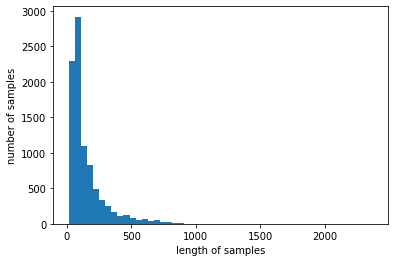

In [37]:
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<br>

In [38]:
# 클래스 분포 확인

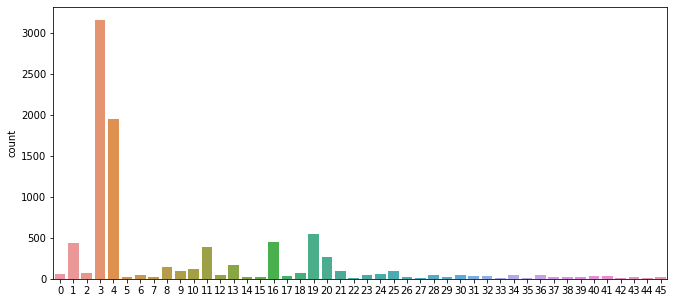

In [39]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

<br>

#### 원본 뉴스 데이터로 복원
<br>

In [40]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

565248/550378 [==============================] - 0s 0us/step


In [41]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [42]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줌.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

<br>

In [43]:
# index_to_word를 통해서 첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원해보기

In [44]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


<br>

In [45]:
# 전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환

In [46]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

In [47]:
x_train = decoded  # train 데이터 변환
print(len(x_train))

8982


In [48]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

In [49]:
x_test = decoded  # test 데이터 변환
print(len(x_test))

2246


<br><br>

#### 벡터화하기
<br>

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

##### DTM 생성

In [51]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)

In [52]:
print(x_train_dtm.shape)

(8982, 26506)


##### TF-IDF 생성

In [53]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

In [54]:
print(tfidfv.shape)

(8982, 26506)


<br><br>

#### 머신러닝 모델 학습 및 예측
<br>

In [55]:
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score  

In [56]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

<br>

In [57]:
# 테스트 데이터에 대한 정확도를 측정하기 위해 테스트 데이터를 TF-IDF 행렬로 변환

In [58]:
x_test_dtm = dtmvector.transform(x_test)              # 테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) # DTM을 TF-IDF 행렬로 변환

<br>

##### 나이브 베이즈 분류기

In [59]:
model_nb = MultinomialNB()
model_nb.fit(tfidfv, y_train)

MultinomialNB()

In [60]:
predicted = model_nb.predict(tfidfv_test)            # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted))  # 예측값과 실제값 비교

정확도: 0.5997328584149599


##### Complement Naive Bayes Classifier(CNB)

In [61]:
model_cnb = ComplementNB()
model_cnb.fit(tfidfv, y_train)

ComplementNB()

In [62]:
predicted = model_cnb.predict(tfidfv_test)           
print("정확도:", accuracy_score(y_test, predicted))  

정확도: 0.7649154051647373


##### 로지스틱 회귀(Logistic Regression)

In [63]:
model_lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
model_lr.fit(tfidfv, y_train)  # 10분 정도 소요됨.

LogisticRegression(C=10000, max_iter=3000)

In [64]:
predicted = model_lr.predict(tfidfv_test)            
print("정확도:", accuracy_score(y_test, predicted))  

정확도: 0.8165627782724845


##### 선형 서포트 벡터 머신(LSVM)

In [65]:
model_lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
model_lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [66]:
predicted = model_lsvc.predict(tfidfv_test)            
print("정확도:", accuracy_score(y_test, predicted))  

정확도: 0.7916295636687445


##### 결정 트리(Decision Tree)

In [67]:
model_tree = DecisionTreeClassifier(max_depth=10, random_state=0)
model_tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [68]:
predicted = model_tree.predict(tfidfv_test)            
print("정확도:", accuracy_score(y_test, predicted))  

정확도: 0.6211041852181657


##### 랜덤 포레스트(Random Forest)

In [69]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=0) # 100개의 트리를 사용
model_forest.fit(tfidfv, y_train)

RandomForestClassifier(random_state=0)

In [70]:
predicted = model_forest.predict(tfidfv_test)            
print("정확도:", accuracy_score(y_test, predicted))  

정확도: 0.7439893143365984


##### 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [71]:
model_grbt = GradientBoostingClassifier(random_state=0)  # verbose=3
model_grbt.fit(tfidfv, y_train)  # 15분 정도 소요됨.

GradientBoostingClassifier(random_state=0)

In [72]:
predicted = model_grbt.predict(tfidfv_test)            
print("정확도:", accuracy_score(y_test, predicted))  

정확도: 0.7702582368655387


##### 보팅(Voting)

In [73]:
# VotingClassifier 생성 
voting_classifier = VotingClassifier(
    estimators=[
        ('model_lr', LogisticRegression(penalty='l2', random_state=0)),
        ('model_cnb', ComplementNB()),
        ('model_grbt', GradientBoostingClassifier(random_state=0))
    ],
    voting='soft' 
)

In [74]:
voting_classifier.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('model_lr', LogisticRegression(random_state=0)),
                             ('model_cnb', ComplementNB()),
                             ('model_grbt',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [75]:
predicted = voting_classifier.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.8000890471950134


<br><br>

### 2. 빈도수 상위 5,000개의 단어만 사용
<br>

#### 훈련 및 테스트 데이터(로이터 뉴스) 로드하기
<br>

In [113]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

<br>

#### 원본 뉴스 데이터로 복원
<br>

In [114]:
decoded = []
for i in range(len(x_train_5k)):
    t = ' '.join([index_to_word.get(index, '<unk>') for index in x_train_5k[i]]) # get 메서드 사용하여 인덱스가 없으면 '<unk>' 반환
    decoded.append(t)

In [115]:
x_train_5k = decoded
print(len(x_train_5k))

8982


In [116]:
decoded = []
for i in range(len(x_test_5k)):
    t = ' '.join([index_to_word.get(index, '<unk>') for index in x_test_5k[i]]) # get 메서드 사용하여 인덱스가 없으면 '<unk>' 반환
    decoded.append(t)

In [117]:
x_test_5k = decoded
print(len(x_test_5k))

2246


<br>

#### 벡터화하기

##### DTM 생성

In [118]:
dtmvector = CountVectorizer()
x_train_dtm_5k = dtmvector.fit_transform(x_train_5k)

In [119]:
print(x_train_dtm_5k.shape)

(8982, 4867)


##### TF-IDF 생성

In [120]:
tfidf_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_dtm_5k)

In [121]:
print(tfidfv_5k.shape)

(8982, 4867)


<br>

#### 머신러닝 모델 학습
<br>

In [85]:
# 데이터를 TF-IDF 행렬로 변환

In [122]:
x_test_dtm_5k = dtmvector.transform(x_test_5k)               # 테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k)  # DTM을 TF-IDF 행렬로 변환

<br>

In [87]:
# 모델별 훈련 및 예측 

In [88]:
def train_predict(tfidfv, y_train, tfidfv_test, y_test):
    # 1) 나이브 베이즈 분류기
    model_nb = MultinomialNB()
    model_nb.fit(tfidfv, y_train)
    
    predicted = model_nb.predict(tfidfv_test)            
    print("정확도_나이브 베이즈 분류기:", accuracy_score(y_test, predicted))  
    
    # 2) Complement Naive Bayes Classifier(CNB)
    model_cnb = ComplementNB()
    model_cnb.fit(tfidfv, y_train)
    
    predicted = model_cnb.predict(tfidfv_test)           
    print("정확도_CNB:", accuracy_score(y_test, predicted))
    
    # 3) 로지스틱 회귀(Logistic Regression)
    model_lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
    model_lr.fit(tfidfv, y_train) 
    
    predicted = model_lr.predict(tfidfv_test)            
    print("정확도_로지스틱 회귀:", accuracy_score(y_test, predicted))  
    
    # 4) 선형 서포트 벡터 머신(LSVM)
    model_lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
    model_lsvc.fit(tfidfv, y_train)
    
    predicted = model_lsvc.predict(tfidfv_test)            
    print("정확도_LSVM:", accuracy_score(y_test, predicted))  
    
    # 5) 결정 트리(Decision Tree)
    model_tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    model_tree.fit(tfidfv, y_train)
    
    predicted = model_tree.predict(tfidfv_test)            
    print("정확도_Decision Tree:", accuracy_score(y_test, predicted))
    
    # 6) 랜덤 포레스트(Random Forest)
    model_forest = RandomForestClassifier(n_estimators=100, random_state=0) # 100개의 트리를 사용
    model_forest.fit(tfidfv, y_train)
    
    predicted = model_forest.predict(tfidfv_test)            
    print("정확도_Random Forest:", accuracy_score(y_test, predicted))  
    
    # 7) 그래디언트 부스팅 트리(GradientBoostingClassifier)
    model_grbt = GradientBoostingClassifier(random_state=0)  # verbose=3
    model_grbt.fit(tfidfv, y_train)  # 15분 정도 소요됨.
    
    predicted = model_grbt.predict(tfidfv_test)            
    print("정확도_GradientBoosting:", accuracy_score(y_test, predicted))  
    
    # 8) 보팅(Voting)
    voting_classifier = VotingClassifier(
        estimators=[
            ('model_lr', LogisticRegression(penalty='l2', random_state=0)),
            ('model_cnb', ComplementNB()),
            ('model_grbt', GradientBoostingClassifier(random_state=0))
        ],
        voting='soft' 
    )
    voting_classifier.fit(tfidfv, y_train)
    
    predicted = voting_classifier.predict(tfidfv_test)
    print("정확도_Voting:", accuracy_score(y_test, predicted))
    
    return model_nb, model_cnb, model_lr, model_lsvc, model_tree, model_forest, model_grbt, voting_classifier

In [89]:
model_nb_5k, model_cnb_5k, model_lr_5k, model_lsvc_5k, model_tree_5k, model_forest_5k, model_grbt_5k, voting_classifier_5k = train_predict(tfidfv_5k, y_train_5k, tfidfv_test_5k, y_test_5k) 

정확도_나이브 베이즈 분류기: 0.6731967943009796
정확도_CNB: 0.7707034728406055
정확도_로지스틱 회귀: 0.8036509349955476


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도_LSVM: 0.7751558325912734
정확도_Decision Tree: 0.6179875333926982
정확도_Random Forest: 0.7582368655387355
정확도_GradientBoosting: 0.767586821015138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


정확도_Voting: 0.7960819234194123


<br><br>

### 3. 직접 단어 개수를 설정해서 사용 (2000개)
<br>

In [90]:
(x_train_2k, y_train_2k), (x_test_2k, y_test_2k) = reuters.load_data(num_words=2000, test_split=0.2)

<br>

In [91]:
decoded = []
for i in range(len(x_train_2k)):
    t = ' '.join([index_to_word[index] for index in x_train_2k[i]])
    decoded.append(t)

In [92]:
x_train_2k = decoded
print(len(x_train_2k))

8982


In [93]:
decoded = []
for i in range(len(x_test_2k)):
    t = ' '.join([index_to_word[index] for index in x_test_2k[i]])
    decoded.append(t)

In [94]:
x_test_2k = decoded
print(len(x_test_2k))

2246


<br>

In [95]:
dtmvector = CountVectorizer()
x_train_dtm_2k = dtmvector.fit_transform(x_train_2k)

In [96]:
print(x_train_dtm_2k.shape)

(8982, 1944)


In [97]:
tfidf_transformer = TfidfTransformer()
tfidfv_2k = tfidf_transformer.fit_transform(x_train_dtm_2k)

In [98]:
print(tfidfv_2k.shape)

(8982, 1944)


<br>

In [99]:
x_test_dtm_2k = dtmvector.transform(x_test_2k) 
tfidfv_test_2k = tfidf_transformer.transform(x_test_dtm_2k) 

In [100]:
model_nb_2k, model_cnb_2k, model_lr_2k, model_lsvc_2k, model_tree_2k, model_forest_2k, model_grbt_2k, voting_classifier_2k = train_predict(tfidfv_2k, y_train_2k, tfidfv_test_2k, y_test_2k) 

정확도_나이브 베이즈 분류기: 0.6914514692787177
정확도_CNB: 0.7569011576135352
정확도_로지스틱 회귀: 0.7773820124666073


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도_LSVM: 0.7341941228851291
정확도_Decision Tree: 0.6255565449688335
정확도_Random Forest: 0.7720391807658059
정확도_GradientBoosting: 0.757346393588602


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


정확도_Voting: 0.7836153161175423


<br><br>

### 단어 개수 및 분류 모델에 따른 accuracy 분석
<br>

#### 1) 모든 단어 사용 시
<br>

+ 정확도_Naive Bayes Classifier: 0.5997328584149599

+ 정확도_CNB: 0.7649154051647373

+ 정확도_Logistic Regression: 0.8165627782724845

+ 정확도_LSVM: 0.792520035618878

+ 정확도_Decision Tree: 0.6211041852181657

+ 정확도_Random Forest: 0.7439893143365984

+ 정확도_GradientBoosting: 0.7702582368655387

+ 정확도_Voting: 0.8000890471950134

<br>

#### 2) 빈도수 상위 5,000개의 단어만 사용
<br>

+ 정확도_Naive Bayes Classifier: 0.6731967943009796

+ 정확도_CNB: 0.7707034728406055

+ 정확도_Logistic Regression: 0.8036509349955476

+ 정확도_LSVM: 0.7787177203918076

+ 정확도_Decision Tree: 0.6179875333926982

+ 정확도_Random Forest: 0.7582368655387355

+ 정확도_GradientBoosting: 0.767586821015138

+ 정확도_Voting: 0.7960819234194123

<br>

#### 3) 2000개 사용 시
<br>

+ 정확도_Naive Bayes Classifier: 0.6914514692787177

+ 정확도_CNB: 0.7569011576135352

+ 정확도_Logistic Regression: 0.7773820124666073

+ 정확도_LSVM: 0.7315227070347284

+ 정확도_Decision Tree: 0.6255565449688335

+ 정확도_Random Forest: 0.7720391807658059

+ 정확도_GradientBoosting: 0.757346393588602

+ 정확도_Voting: 0.7836153161175423

<br><br>

### 단어 크기에 따른 분류 모델의 F1 score 비교
<br>

##### Voting 모델 (모든 단어 사용 시)
<br>

In [103]:
# 예측 확률 계산
prediction_probabilities = voting_classifier.predict_proba(tfidfv_test)

# 가장 확률이 높은 클래스의 인덱스를 찾음
prediction = np.argmax(prediction_probabilities, axis=1)

In [104]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("정확도:", accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))

정확도: 0.8000890471950134
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.80      0.78      0.79       105
           2       0.67      0.70      0.68        20
           3       0.91      0.93      0.92       813
           4       0.78      0.89      0.83       474
           5       1.00      0.20      0.33         5
           6       0.77      0.71      0.74        14
           7       1.00      0.33      0.50         3
           8       0.67      0.68      0.68        38
           9       0.95      0.80      0.87        25
          10       0.83      0.80      0.81        30
          11       0.68      0.71      0.69        83
          12       0.50      0.46      0.48        13
          13       0.65      0.59      0.62        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
          16       0.76      0.73      0.74        99
   

<br>

##### Voting 모델 (빈도수 상위 5,000개의 단어만 사용 시)
<br>

In [124]:
# 예측 확률 계산
prediction_probabilities = voting_classifier.predict_proba(tfidfv_test_5k)

# 가장 확률이 높은 클래스의 인덱스를 찾음
prediction = np.argmax(prediction_probabilities, axis=1)

In [108]:
print("정확도:", accuracy_score(y_test_5k, prediction))
print(classification_report(y_test_5k, prediction))

정확도: 0.8000890471950134
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.80      0.78      0.79       105
           2       0.67      0.70      0.68        20
           3       0.91      0.93      0.92       813
           4       0.78      0.89      0.83       474
           5       1.00      0.20      0.33         5
           6       0.77      0.71      0.74        14
           7       1.00      0.33      0.50         3
           8       0.67      0.68      0.68        38
           9       0.95      0.80      0.87        25
          10       0.83      0.80      0.81        30
          11       0.68      0.71      0.69        83
          12       0.50      0.46      0.48        13
          13       0.65      0.59      0.62        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
          16       0.76      0.73      0.74        99
   

<br>

In [128]:
# 예측 확률 계산
prediction_probabilities = voting_classifier.predict_proba(tfidfv_test_2k)

# 가장 확률이 높은 클래스의 인덱스를 찾음
prediction = np.argmax(prediction_probabilities, axis=1)

In [126]:
print("정확도:", accuracy_score(y_test_2k, prediction))
print(classification_report(y_test_2k, prediction))

정확도: 0.8000890471950134
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.80      0.78      0.79       105
           2       0.67      0.70      0.68        20
           3       0.91      0.93      0.92       813
           4       0.78      0.89      0.83       474
           5       1.00      0.20      0.33         5
           6       0.77      0.71      0.74        14
           7       1.00      0.33      0.50         3
           8       0.67      0.68      0.68        38
           9       0.95      0.80      0.87        25
          10       0.83      0.80      0.81        30
          11       0.68      0.71      0.69        83
          12       0.50      0.46      0.48        13
          13       0.65      0.59      0.62        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
          16       0.76      0.73      0.74        99
   

<br><br>

### 4. 딥러닝 모델과 비교해 보기
<br>

#### RNN(LSTM) 모델로 학습하기
<br>

In [129]:
# 빈도수 상위 5,000개의 단어 dataset 이용

In [147]:
print(tfidfv_5k.shape) 
print(y_train_5k.shape)

(8982, 4867)
(8982,)


<br>

In [148]:
# 희소 행렬을 NumPy 배열로 변환
tfidfv_5k_array = tfidfv_5k.toarray()

In [149]:
from tensorflow.keras.utils import to_categorical

# 원-핫 인코딩 적용
y_train_5k_one_hot = to_categorical(y_train_5k, num_classes=num_classes)

<br>

In [150]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2

In [151]:
vocab_size = 5000
word_vector_dim = 64 
num_classes = 46  # 로이터 데이터셋의 클래스 수
L2_lambda = 1e-4  # L2 정규화 계수

In [152]:
model_LSTM = Sequential([
    Embedding(vocab_size, word_vector_dim, input_length=None), # input_length는 필요한 경우 지정할 수 있습니다.
    Bidirectional(LSTM(64, kernel_regularizer=l2(L2_lambda), return_sequences=True)), # 양방향 LSTM
    BatchNormalization(),
    Dropout(0.5), # Dropout 레이어 추가
    LSTM(32, kernel_regularizer=l2(L2_lambda)),
    BatchNormalization(),
    Dropout(0.5), # Dropout 레이어 추가
    Dense(num_classes, activation='softmax')
])

In [153]:
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 128)         512       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                20608     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)                128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)               

In [154]:
# 모델 컴파일
model_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [155]:
# 모델 훈련
history = model_LSTM.fit(tfidfv_5k_array, y_train_5k_one_hot, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
57/57 [==============================] - 39s 628ms/step - loss: 4.3108 - accuracy: 0.0434 - val_loss: 3.6771 - val_accuracy: 0.0445
Epoch 2/5
57/57 [==============================] - 35s 610ms/step - loss: 3.8674 - accuracy: 0.0905 - val_loss: 3.4797 - val_accuracy: 0.0445
Epoch 3/5
57/57 [==============================] - 35s 608ms/step - loss: 3.5221 - accuracy: 0.1665 - val_loss: 3.1771 - val_accuracy: 0.3450
Epoch 4/5
57/57 [==============================] - 35s 612ms/step - loss: 3.1738 - accuracy: 0.2511 - val_loss: 3.1019 - val_accuracy: 0.2220
Epoch 5/5
57/57 [==============================] - 35s 608ms/step - loss: 2.8513 - accuracy: 0.3084 - val_loss: 2.6271 - val_accuracy: 0.3450


<br>

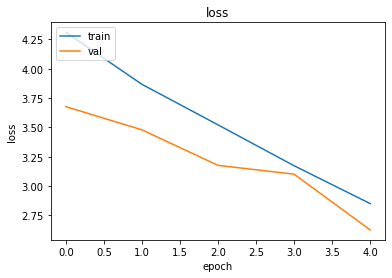

In [156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

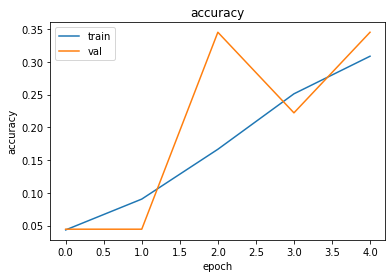

In [157]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<br>

In [130]:
# 예측을 위한 훈련 및 테스트 데이터 전처리

In [158]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 토크나이저 정의 (훈련 데이터에 사용한 것과 동일해야 함)
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)  

# 테스트 데이터 토큰화
x_test_sequences = tokenizer.texts_to_sequences(x_test)  

# 패딩
x_test_padded = pad_sequences(x_test_sequences, maxlen=max(len(l) for l in x_train))

In [159]:
# 원-핫 인코딩 적용
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [160]:
# 모델 평가
test_loss, test_accuracy = model_LSTM.evaluate(x_test_padded, y_test_one_hot)
print(f'Test accuracy: {test_accuracy}')

71/71 [==============================] - 24s 318ms/step - loss: 2.6071 - accuracy: 0.3620
Test accuracy: 0.36197686195373535


In [161]:
# 테스트 데이터 토큰화
x_test_sequences = tokenizer.texts_to_sequences(x_test)  

# 패딩
x_test_padded = pad_sequences(x_test_sequences, maxlen=max(len(l) for l in x_train))

<br>

In [ ]:
# 모델 예측
predictions = model_LSTM.predict(x_test_padded)

In [162]:
predictions

array([[0.0133548 , 0.03335145, 0.01149791, ..., 0.00797594, 0.00853876,
        0.0095059 ],
       [0.01332119, 0.0333331 , 0.01147635, ..., 0.00794987, 0.00853468,
        0.00948157],
       [0.01326131, 0.03317604, 0.01143975, ..., 0.00792133, 0.00851229,
        0.00942805],
       ...,
       [0.01325458, 0.03330901, 0.01144173, ..., 0.0079073 , 0.0085095 ,
        0.00943479],
       [0.01332501, 0.0333737 , 0.0115573 , ..., 0.00795474, 0.00852901,
        0.00952018],
       [0.01329392, 0.03333624, 0.01151206, ..., 0.00794728, 0.00852634,
        0.00948699]], dtype=float32)

<br>

In [131]:
# 딥러닝 모델(LSTM)의 F1 Score 결과

In [166]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00       105
           2       0.00      0.00      0.00        20
           3       0.36      1.00      0.53       813
           4       0.00      0.00      0.00       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.00      0.00      0.00        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00        99
          17       0.00    

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<br>

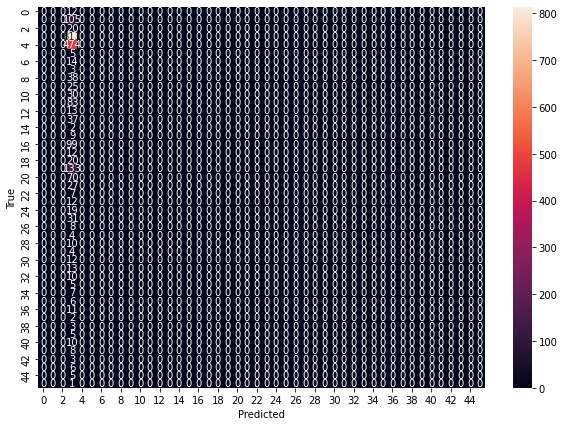

In [164]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델의 예측값 얻기
y_pred = model_LSTM.predict(x_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<br><br>

## 6-2. 프로젝트 제출
<br>

### 루브릭
<br>

#### 평가문항과 상세기준
<br>

##### 1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?

3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출

<br>

##### 2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.

<br>

##### 3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.